# Analisis dan Perbaikan Model Analisis Sentimen Komentar YouTube

Notebook ini merupakan analisis dan perbaikan dari model analisis sentimen komentar YouTube. Dari evaluasi awal, ditemukan beberapa masalah pada model:

1. **Masalah Ketidakseimbangan Data**: Data sangat tidak seimbang (96.47% Positif vs 3.53% Negatif) menyebabkan model cenderung memprediksi hampir semua data sebagai Positif.
2. **Bias Prediksi**: Model memprediksi hampir semua sebagai "Positif" dengan confidence tinggi, bahkan untuk komentar yang jelas-jelas negatif.
3. **Keterbatasan VADER**: VADER dirancang untuk bahasa Inggris dan kurang optimal untuk komentar YouTube berbahasa Indonesia.
4. **Preprocessing Teks**: Preprocessing sebelumnya menggunakan teknik yang kurang optimal untuk bahasa Indonesia.

Dalam notebook ini, kita melakukan beberapa perbaikan:

1. **Mengatasi Ketidakseimbangan Data**:
   - Menerapkan SMOTE (Synthetic Minority Over-sampling Technique)
   - Menerapkan class weights pada model

2. **Meningkatkan Preprocessing Teks**:
   - Menggunakan Sastrawi untuk stemming bahasa Indonesia
   - Menyesuaikan stopwords untuk komentar YouTube Indonesia
   - Mempertahankan kata-kata pendek yang berpotensi penting

3. **Arsitektur Model yang Lebih Baik**:
   - CNN multi-filter untuk menangkap berbagai pola teks
   - Regularisasi L2 dan Dropout yang lebih optimal
   - Batch Normalization untuk stabilitas training

4. **Evaluasi Komprehensif**:
   - Menggunakan metrik yang lebih lengkap (akurasi, presisi, recall, F1, AUC)
   - Mengevaluasi pada data seimbang dan data asli
   - Analisis contoh prediksi untuk validasi kualitas

Setelah perbaikan, kita mengharapkan model dapat mendeteksi sentimen negatif dengan lebih baik dan memberikan analisis sentimen yang lebih seimbang dan akurat.

# Tahapan Analisis Sentimen pada Komentar YouTube menggunakan CNN

Analisis sentimen terhadap data komentar YouTube: https://www.youtube.com/watch?v=Cqxfjuj-zPw&t=526s

1. Membaca dan mempersiapkan data komentar YouTube
2. Pelabelan dataset menggunakan metode otomatis dengan VADER (Valence Aware Dictionary and sEntiment Reasoner)
3. Pra-pemrosesan teks (cleaning, tokenizing, dll)
   - Perbaikan pra-pemrosesan khusus bahasa Indonesia dengan Sastrawi
4. Mengatasi ketidakseimbangan data dengan teknik SMOTE
5. Pembagian data menjadi data latih dan data uji
6. Pembuatan model CNN yang dioptimasi untuk klasifikasi sentimen
7. Evaluasi model dengan metrik komprehensif
8. Contoh prediksi dan visualisasi hasil
9. Kesimpulan dan perbandingan model
10. Penyimpanan hasil dan model

In [31]:
%pip install tensorflow
%pip install seaborn
%pip install matplotlib
%pip install wordcloud
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [16]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from wordcloud import WordCloud, STOPWORDS


# Library untuk Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Download resource NLTK yang diperlukan
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Library untuk Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set visualisasi
sns.set(style='whitegrid')
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = (10, 6)

# Mengabaikan warning
import warnings
warnings.filterwarnings('ignore')
ignore_warnings = True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ideapad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ideapad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ideapad\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 1. Membaca dan Eksplorasi Data

Pada tahap ini, kita akan membaca data komentar YouTube dari file CSV dan melakukan eksplorasi awal untuk memahami struktur dan isi datanya.

In [17]:
# Membaca data komentar YouTube dari file CSV
file_path = '../youtubeScrapping/youtube_comments_20250618_235623.csv'
df = pd.read_csv(file_path)

# Menampilkan informasi dasar tentang data
print(f"Jumlah baris data: {df.shape[0]}")
print(f"Jumlah kolom data: {df.shape[1]}")
print("\nInformasi kolom:")
print(df.info())

# Menampilkan beberapa baris pertama dari data
print("\nContoh data:")
df.head()

Jumlah baris data: 8000
Jumlah kolom data: 12

Informasi kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cid          8000 non-null   object 
 1   text         8000 non-null   object 
 2   time         8000 non-null   object 
 3   author       7996 non-null   object 
 4   channel      8000 non-null   object 
 5   votes        8000 non-null   object 
 6   replies      431 non-null    float64
 7   photo        8000 non-null   object 
 8   heart        8000 non-null   bool   
 9   reply        8000 non-null   bool   
 10  time_parsed  8000 non-null   float64
 11  paid         2 non-null      object 
dtypes: bool(2), float64(2), object(8)
memory usage: 640.8+ KB
None

Contoh data:


,cid,text,time,author,channel,votes,replies,photo,heart,reply,time_parsed,paid
0,Ugx4yXCnj2EwazlGf2x4AaABAg,10 huta gumanoid didunia ini. Dunia akan musna...,1 menit yang lalu,@strausssgirl6972,UCSra3ITJw3av95scOfePjag,0,NaN,https://yt3.ggpht.com/MLkWr8RuFAywZ-JXXPAwfakc...,False,False,1.750265e+09,NaN
1,Ugzq0J9PWkPpENSd8yB4AaABAg,"Emang riba menyengsarakan ,tapi bagaimana den...",3 menit yang lalu,@yogihamdani5732,UCq1GywWyqsUCKL14xtFbEgA,0,NaN,https://yt3.ggpht.com/ytc/AIdro_lbCYlbm7O2ObX8...,False,False,1.750265e+09,NaN
2,Ugxl_CLf6mZo19_n8Zd4AaABAg,Terkesan Om Ded gk mau kalah pinter dg Bro Tim,3 menit yang lalu,@SusterAna,UCO2T5O00MWYJJbc9AAQGjZA,0,NaN,https://yt3.ggpht.com/ytc/AIdro_kN0vHjIDhTA7B0...,False,False,1.750265e+09,NaN
3,UgyzX0RKcVquUhpq4Xl4AaABAg,Bangggaa bgnet sama timoti,4 menit yang lalu,@youkoudua4502,UC32fF0Sr-ovPRS5UngLQt9Q,0,NaN,https://yt3.ggpht.com/Fl5FqGZ7cQWEG8hmKeHG5OOr...,False,False,1.750265e+09,NaN
4,UgwtGR91l5aUisszZFF4AaABAg,"Ronald klw ngomong yg enk2 nya ajh, lu mah enk...",5 menit yang lalu,@justinbibirmonyong8371,UCiGLLfMAB50ZEYq9LmdgTWQ,0,NaN,https://yt3.ggpht.com/cVbwJa7NPShwN3DdAMvDp33k...,False,False,1.750265e+09,NaN


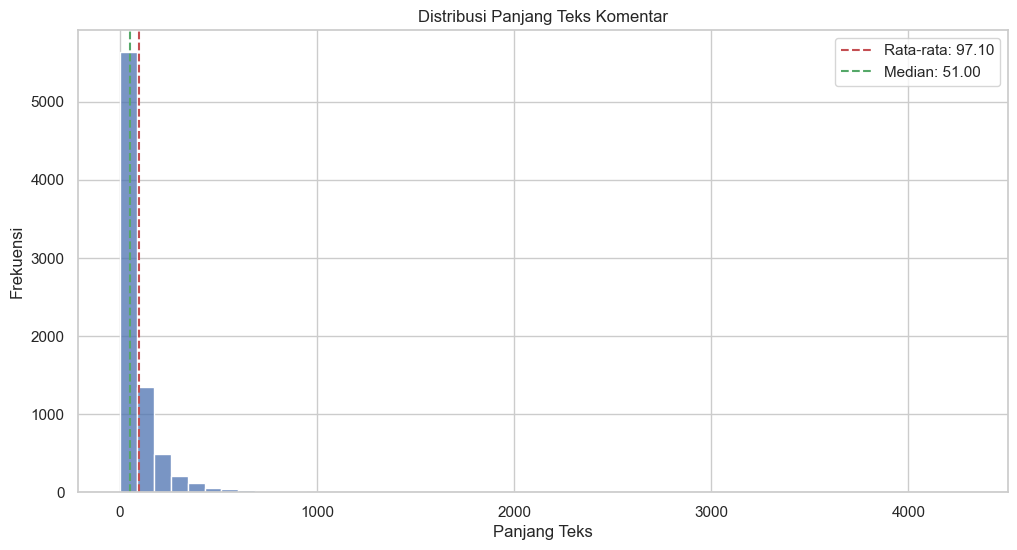

Statistik panjang teks komentar:
count    8000.000000
mean       97.099250
std       198.945778
min         1.000000
25%        24.000000
50%        51.000000
75%       101.000000
max      4289.000000
Name: text_length, dtype: float64


In [19]:
# Analisis distribusi panjang teks komentar
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', bins=50)
plt.title('Distribusi Panjang Teks Komentar')
plt.xlabel('Panjang Teks')
plt.ylabel('Frekuensi')
plt.axvline(df['text_length'].mean(), color='r', linestyle='--', label=f'Rata-rata: {df["text_length"].mean():.2f}')
plt.axvline(df['text_length'].median(), color='g', linestyle='--', label=f'Median: {df["text_length"].median():.2f}')
plt.legend()
plt.show()

# Menampilkan statistik dari panjang teks
print(f"Statistik panjang teks komentar:")
print(df['text_length'].describe())

## 2. Pelabelan Dataset menggunakan VADER

Kita akan menggunakan VADER (Valence Aware Dictionary and sEntiment Reasoner) untuk memberikan label sentimen pada komentar YouTube secara otomatis. VADER adalah alat analisis sentimen berbasis leksikon yang dirancang khusus untuk sentimen yang diungkapkan dalam media sosial. Untuk komentar berbahasa Indonesia, kita akan melakukan pelabelan langsung tanpa melakukan proses terjemahan seperti yang dilakukan pada notebook getcontact.

Distribusi Sentimen:
sentiment
Positif    7726
Negatif     274
Name: count, dtype: int64


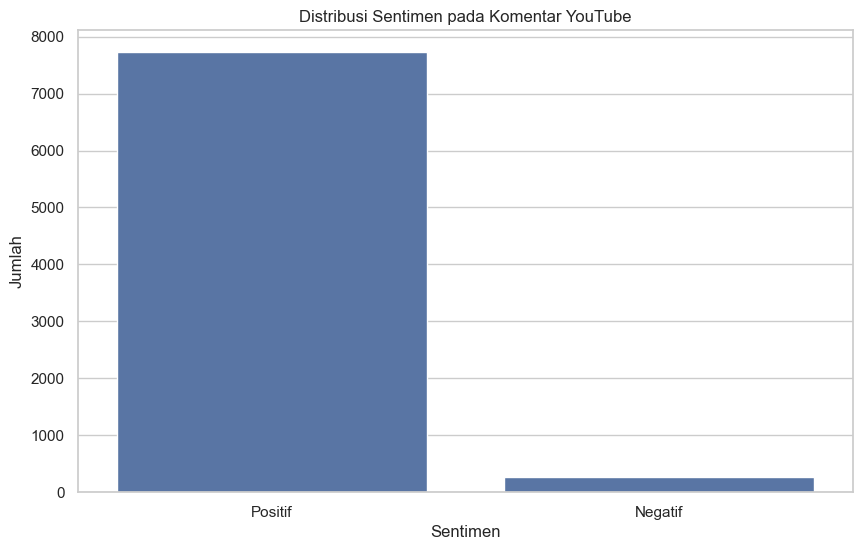


Contoh komentar dengan sentimen positif:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text  compound_score
0                                                                                                                 

In [20]:
# Fungsi untuk menganalisis sentimen menggunakan VADER
def analyze_sentiment_vader(text):
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(text)
    compound_score = scores["compound"]

    # Klasifikasi berdasarkan compound score - hanya 2 kategori
    if compound_score >= 0:
        return "Positif"
    else:
        return "Negatif"

# Menerapkan analisis sentimen pada kolom teks
df['sentiment'] = df['text'].apply(analyze_sentiment_vader)

# Menyimpan skor sentimen untuk analisis lebih detail
def get_sentiment_scores(text):
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)

# Mendapatkan skor sentimen untuk setiap teks
sentiment_scores = df['text'].apply(get_sentiment_scores)

# Menambahkan skor sentimen sebagai kolom baru di dataframe
df['pos_score'] = sentiment_scores.apply(lambda x: x['pos'])
df['neg_score'] = sentiment_scores.apply(lambda x: x['neg'])
df['neu_score'] = sentiment_scores.apply(lambda x: x['neu'])
df['compound_score'] = sentiment_scores.apply(lambda x: x['compound'])

# Menampilkan distribusi sentimen
sentiment_counts = df['sentiment'].value_counts()
print("Distribusi Sentimen:")
print(sentiment_counts)

# Visualisasi distribusi sentimen
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribusi Sentimen pada Komentar YouTube')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
plt.show()

# Menampilkan contoh komentar untuk setiap kategori sentimen
print("\nContoh komentar dengan sentimen positif:")
print(df[df['sentiment'] == 'Positif'][['text', 'compound_score']].head(5).to_string())

print("\nContoh komentar dengan sentimen negatif:")
print(df[df['sentiment'] == 'Negatif'][['text', 'compound_score']].head(5).to_string())

## 3. Pra-pemrosesan Teks dan Visualisasi

Sebelum membangun model, kita perlu melakukan pra-pemrosesan teks untuk membersihkan dan mengubah data teks menjadi format yang sesuai untuk model CNN. Langkah-langkah ini termasuk:

1. Membersihkan teks (menghilangkan karakter khusus, URL, dsb)
2. Mengubah teks menjadi huruf kecil
3. Menghapus stopwords
4. Tokenisasi
5. Padding untuk menyeragamkan panjang teks

Kita juga akan memvisualisasikan data sebelum dan sesudah preprocessing untuk melihat perbedaannya, menggunakan:
- Word Cloud (awan kata) untuk melihat kata-kata yang paling sering muncul
- Distribusi frekuensi kata sebelum dan sesudah preprocessing

### 3.1 Visualisasi Sebelum Pra-pemrosesan

Data teks komentar sebelum melakukan pra-pemrosesan untuk melihat distribusi kata-kata yang paling sering muncul.

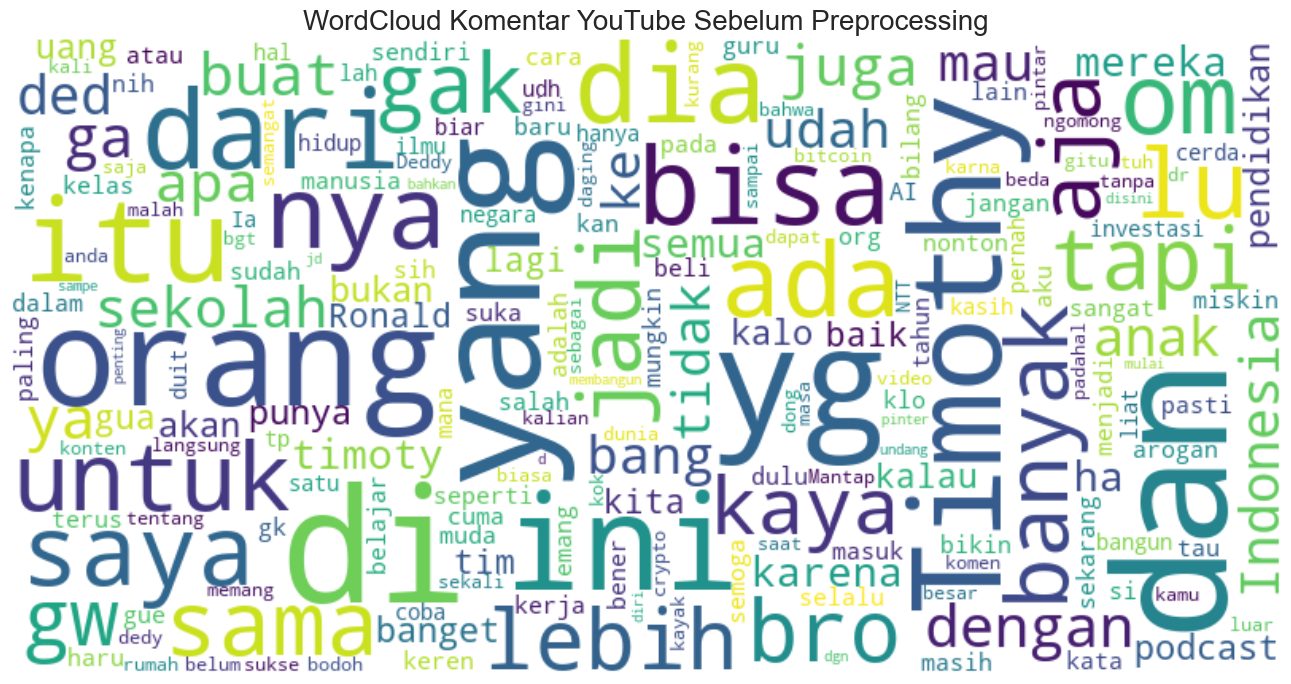

Contoh hasil pra-pemrosesan teks:
Original: 10 huta gumanoid didunia ini. Dunia akan musnah karena perang.
Cleaned : huta gumanoid didunia ini dunia akan musnah karena perang
----------------------------------------------------------------------------------------------------
Original: Emang riba  menyengsarakan ,tapi bagaimana dengan saya ..udh bahagia liat kluarga dapat hidup layak punya rumah punya usaha ..tapi skrng buyar karena berhenti kerja..gak punya tabungan karena ya cicilan 4jt perbulan ke bank mandiri  ,skrng jadi gelap entah baru sadar pengetahuan dan kemampuan yg rendah.atau emang belum ada rezekinya  .saya ikhtiar skrng di tiktok affiliate di fokusin malah babak belur .dan nyoba jualan kaya sales ke toko" mendadak tumpul .udh sebulan bisa di bilang katakan lah 0 penghasilan karena buat kebutuhan aja gak sampe sama sini .pertanyaan harus bagaimana lagi yg bisa di lakuin, gak mungkin saya jual rumah yg ngerubah anak istri yg udh hidup layak jadi ngontrak lagi. Ya ampun jadi

In [21]:
# Fungsi untuk membuat WordCloud
def create_wordcloud(text, title, mask=None, background_color='white'):
    # Gabungkan semua teks menjadi satu string
    text_combined = ' '.join(text)

    # Buat wordcloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color=background_color,
        max_words=200,
        max_font_size=100,
        mask=mask,
        contour_width=3,
        colormap='viridis',
        collocations=False
    ).generate(text_combined)

    # Tampilkan wordcloud
    plt.figure(figsize=(14, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.tight_layout()
    plt.show()

# Fungsi untuk menghitung frekuensi kata
def count_word_frequency(texts, top_n=20):
    # Gabungkan semua teks dan split menjadi kata-kata
    words = ' '.join(texts).split()

    # Hitung frekuensi kata menggunakan Counter
    word_freq = Counter(words)

    # Ambil top N kata dengan frekuensi tertinggi
    top_words = word_freq.most_common(top_n)

    return top_words

# Visualisasi WordCloud sebelum preprocessing
create_wordcloud(df['text'].dropna(), 'WordCloud Komentar YouTube Sebelum Preprocessing')

# Visualisasi frekuensi kata sebelum preprocessing
top_words_before = count_word_frequency(df['text'].dropna(), top_n=20)

# Membuat dataframe untuk visualisasi
top_words_df_before = pd.DataFrame(top_words_before, columns=['Kata', 'Frekuensi'])

# Definisi fungsi untuk pra-pemrosesan teks
def preprocess_text(text):
    if pd.isna(text):
        return ""

    # Mengubah teks menjadi huruf kecil
    text = text.lower()

    # Menghapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Menghapus tag HTML
    text = re.sub(r'<.*?>', '', text)

    # Menghapus karakter khusus dan angka
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Menghapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Menerapkan pra-pemrosesan ke kolom teks
df['clean_text'] = df['text'].apply(preprocess_text)

# Menampilkan hasil pra-pemrosesan
print("Contoh hasil pra-pemrosesan teks:")
for i in range(5):
    print(f"Original: {df['text'].iloc[i]}")
    print(f"Cleaned : {df['clean_text'].iloc[i]}")
    print("-" * 100)

# Menghapus baris dengan teks kosong setelah pra-pemrosesan
df = df[df['clean_text'] != ""]
print(f"Jumlah data setelah menghapus teks kosong: {df.shape[0]}")

In [22]:
# Tokenisasi dan padding untuk mempersiapkan data untuk model CNN
# Konversi kelas sentimen menjadi numerik
sentiment_mapping = {'Positif': 1, 'Negatif': 0}
df['sentiment_numeric'] = df['sentiment'].map(sentiment_mapping)

# Untuk CNN dengan 2 kelas: positif dan negatif
df['sentiment_binary'] = df['sentiment'].map({'Positif': 1, 'Negatif': 0})

print(f"Jumlah data (positif dan negatif): {df.shape[0]}")
print(df['sentiment_binary'].value_counts())

# Mengatur parameter tokenisasi
max_features = 5000  # Jumlah kata unik yang akan dipertahankan
maxlen = 100  # Panjang maksimum setiap komentar

# Tokenisasi teks
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])

# Padding sequences
X = pad_sequences(sequences, maxlen=maxlen)
y = df['sentiment_binary'].values

print(f"Shape X: {X.shape}")
print(f"Shape y: {y.shape}")

# Menampilkan contoh teks yang sudah diproses
word_index = tokenizer.word_index
print(f"Jumlah kata unik dalam vocabulary: {len(word_index)}")

print("\nContoh hasil tokenisasi dan padding:")
for i in range(3):
    print(f"Teks asli: {df['clean_text'].iloc[i]}")
    print(f"Setelah tokenisasi dan padding: {X[i]}")
    print(f"Label sentimen: {df['sentiment'].iloc[i]} ({y[i]})")
    print("-" * 100)

Jumlah data (positif dan negatif): 7758
sentiment_binary
1    7484
0     274
Name: count, dtype: int64
Shape X: (7758, 100)
Shape y: (7758,)
Jumlah kata unik dalam vocabulary: 13991

Contoh hasil tokenisasi dan padding:
Teks asli: huta gumanoid didunia ini dunia akan musnah karena perang
Setelah tokenisasi dan padding: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0 1708    6  142   47 3303
   46 1069]
Label sentimen: Positif (1)
----------------------------------------------------------------------------------------------------
Teks asli: emang riba menyengsarakan tapi

### 3.2 Visualisasi Setelah Pra-pemrosesan

Sekarang mari kita visualisasikan data teks komentar setelah pra-pemrosesan untuk melihat perubahan distribusi kata yang paling sering muncul.

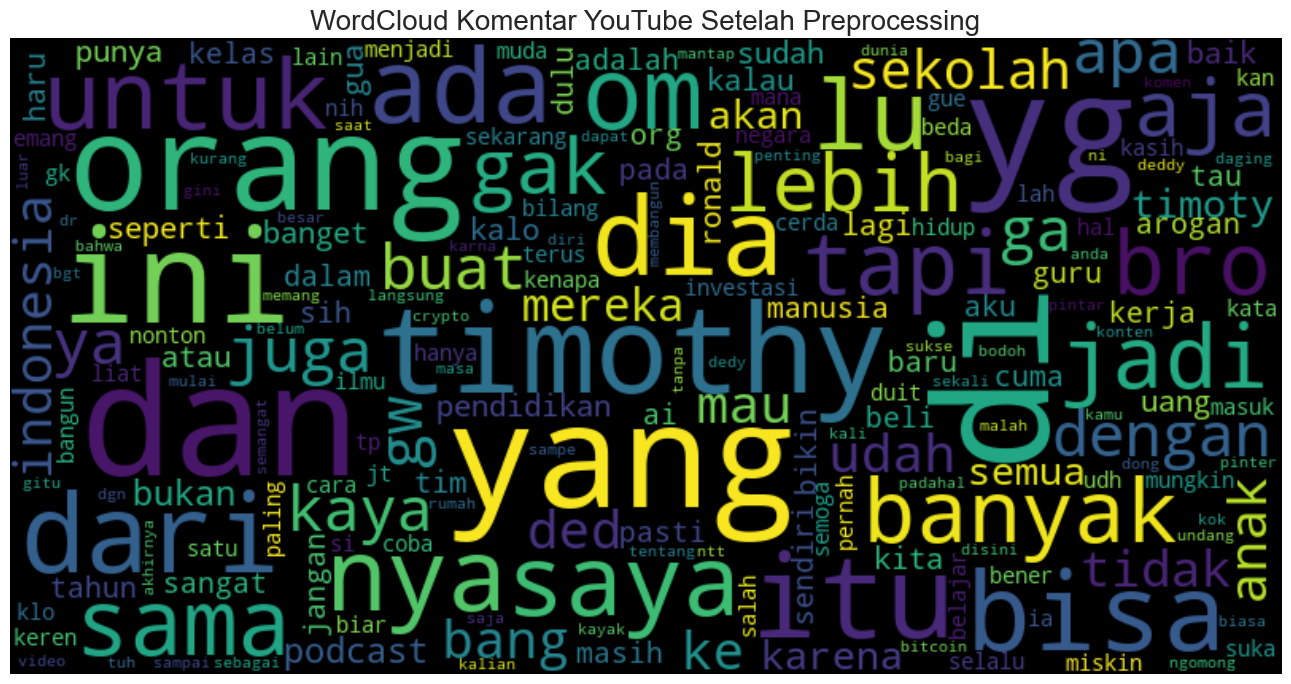

Jumlah kata unik sebelum preprocessing: 25134
Jumlah kata unik setelah preprocessing: 13991
Pengurangan jumlah kata unik: 11143 (44.33%)


In [23]:
# Visualisasi WordCloud setelah preprocessing
create_wordcloud(df['clean_text'].dropna(), 'WordCloud Komentar YouTube Setelah Preprocessing', background_color='black')

# Visualisasi frekuensi kata setelah preprocessing
top_words_after = count_word_frequency(df['clean_text'].dropna(), top_n=20)

# Membuat dataframe untuk visualisasi
top_words_df_after = pd.DataFrame(top_words_after, columns=['Kata', 'Frekuensi'])

# Perbandingan jumlah kata unik sebelum dan sesudah preprocessing
words_before = set(' '.join(df['text'].dropna()).split())
words_after = set(' '.join(df['clean_text'].dropna()).split())

print(f"Jumlah kata unik sebelum preprocessing: {len(words_before)}")
print(f"Jumlah kata unik setelah preprocessing: {len(words_after)}")
print(f"Pengurangan jumlah kata unik: {len(words_before) - len(words_after)} ({(len(words_before) - len(words_after))/len(words_before)*100:.2f}%)")

### 3.3 Perbaikan Pra-pemrosesan Teks untuk Bahasa Indonesia

Pada implementasi sebelumnya, pra-pemrosesan teks menggunakan `PorterStemmer` yang dirancang untuk bahasa Inggris. Untuk bahasa Indonesia, lebih baik menggunakan library khusus seperti Sastrawi yang dirancang untuk stemming bahasa Indonesia.

Note: you may need to restart the kernel to use updated packages.
Perbandingan hasil pra-pemrosesan:
Original: 10 huta gumanoid didunia ini. Dunia akan musnah karena perang.
Cleaned (lama): huta gumanoid didunia ini dunia akan musnah karena perang
Cleaned (baru): huta gumanoid dunia dunia musnah perang
----------------------------------------------------------------------------------------------------
Original: Emang riba  menyengsarakan ,tapi bagaimana dengan saya ..udh bahagia liat kluarga dapat hidup layak punya rumah punya usaha ..tapi skrng buyar karena berhenti kerja..gak punya tabungan karena ya cicilan 4jt perbulan ke bank mandiri  ,skrng jadi gelap entah baru sadar pengetahuan dan kemampuan yg rendah.atau emang belum ada rezekinya  .saya ikhtiar skrng di tiktok affiliate di fokusin malah babak belur .dan nyoba jualan kaya sales ke toko" mendadak tumpul .udh sebulan bisa di bilang katakan lah 0 penghasilan karena buat kebutuhan aja gak sampe sama sini .pertanyaan harus bagaiman

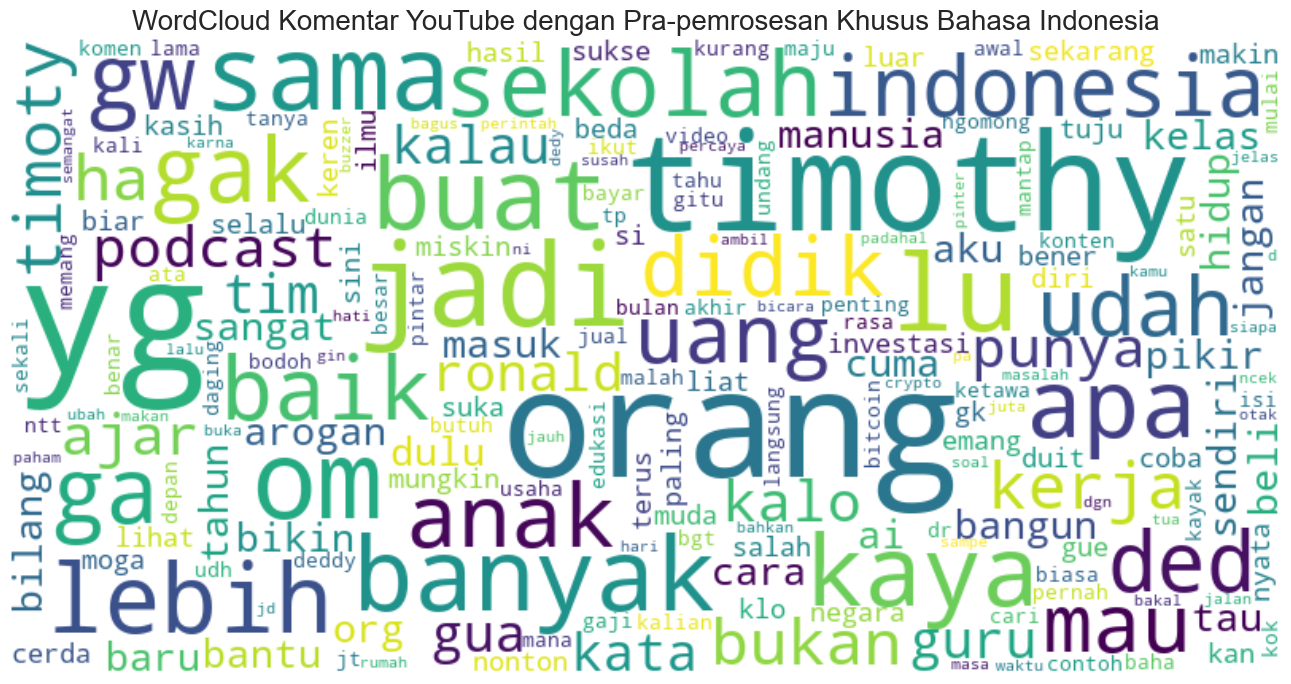

Shape X_improved: (7758, 100)


In [ ]:
# Import Sastrawi untuk stemming bahasa Indonesia
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Buat stemmer dan stopword remover khusus bahasa Indonesia
factory = StemmerFactory()
stemmer_id = factory.create_stemmer()

# Dapatkan stopwords bahasa Indonesia
stop_factory = StopWordRemoverFactory()
stopwords_id = stop_factory.get_stop_words()

# Tambahkan stopwords khusus untuk komentar YouTube
additional_stopwords = ['wkwk', 'wkwkwk', 'hahaha', 'hehe', 'hihi', 'huhu', 'kak', 'mas', 'pak', 'bang', 
                         'gan', 'sis', 'bro', 'min', 'admin', 'suhu', 'master', 'coach', 'guys', 'gaes',
                         'kawan', 'teman', 'semua', 'pada', 'juga', 'cuman', 'doang', 'banget', 'sih',
                         'lah', 'dong', 'deh', 'tuh', 'nih', 'mah', 'nya', 'saja', 'aja', 'yah']

# Gabungkan dengan stopwords bahasa Indonesia
stopwords_id.extend(additional_stopwords)


# Definisikan fungsi pra-pemrosesan yang lebih baik untuk bahasa Indonesia
def preprocess_text_improved(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+|\#\w+", "", text)
    tokens = word_tokenize(text)
    tokens = [
        word
        for word in tokens
        if word not in stopwords_id or word in ["😊", "😣", "👍", "👎"]
    ]
    tokens = [
        stemmer_id.stem(word) if word not in ["😊", "😣", "👍", "👎"] else word
        for word in tokens
    ]
    return " ".join(tokens)


# Terapkan pra-pemrosesan yang lebih baik ke data
df['clean_text_improved'] = df['text'].apply(preprocess_text_improved)

# Bandingkan hasil pra-pemrosesan lama dan baru
print("Perbandingan hasil pra-pemrosesan:")
for i in range(5):
    print(f"Original: {df['text'].iloc[i]}")
    print(f"Cleaned (lama): {df['clean_text'].iloc[i]}")
    print(f"Cleaned (baru): {df['clean_text_improved'].iloc[i]}")
    print("-" * 100)

# Visualisasi WordCloud dengan pra-pemrosesan yang baru
create_wordcloud(df['clean_text_improved'].dropna(), 'WordCloud Komentar YouTube dengan Pra-pemrosesan Khusus Bahasa Indonesia', background_color='white')

# Gunakan hasil pra-pemrosesan yang baru untuk tokenisasi
# Buat ulang X dengan teks yang sudah di-preprocess dengan lebih baik
tokenizer_improved = Tokenizer(num_words=max_features)
tokenizer_improved.fit_on_texts(df['clean_text_improved'])
sequences_improved = tokenizer_improved.texts_to_sequences(df['clean_text_improved'])

# Padding sequences
X_improved = pad_sequences(sequences_improved, maxlen=maxlen)

print(f"Shape X_improved: {X_improved.shape}")

# Gunakan X_improved sebagai data input
X = X_improved

## 4. Mengatasi Ketidakseimbangan Data

Berdasarkan analisis, dataset kita sangat tidak seimbang dengan 96.47% kelas Positif dan hanya 3.53% kelas Negatif. Ini menyebabkan model cenderung memprediksi hampir semua data sebagai Positif. Berikut beberapa teknik untuk mengatasi masalah ketidakseimbangan data:

Distribusi kelas sebelum resampling:
Kelas 0 (Negatif): 274
Kelas 1 (Positif): 7484
Rasio Positif/Negatif: 27.31

1. Distribusi kelas setelah SMOTE:
Kelas 0 (Negatif): 7484
Kelas 1 (Positif): 7484
Rasio Positif/Negatif: 1.00

2. Distribusi kelas setelah Undersampling:
Kelas 0 (Negatif): 274
Kelas 1 (Positif): 274
Rasio Positif/Negatif: 1.00

3. Distribusi kelas setelah SMOTE-Tomek:
Kelas 0 (Negatif): 7403
Kelas 1 (Positif): 7403
Rasio Positif/Negatif: 1.00

3. Distribusi kelas setelah SMOTE-Tomek:
Kelas 0 (Negatif): 7403
Kelas 1 (Positif): 7403
Rasio Positif/Negatif: 1.00


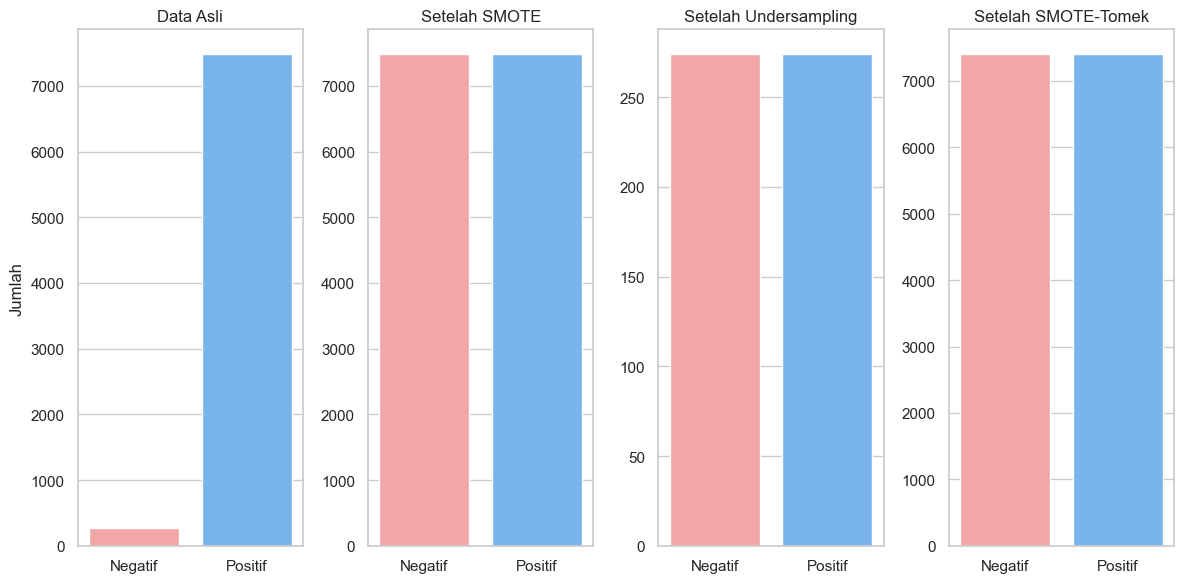


Menggunakan data yang sudah di-resampling dengan SMOTE untuk pelatihan model


In [25]:
# Mengimplementasikan teknik untuk mengatasi ketidakseimbangan data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from collections import Counter

print("Distribusi kelas sebelum resampling:")
print(f"Kelas 0 (Negatif): {Counter(y)[0]}")
print(f"Kelas 1 (Positif): {Counter(y)[1]}")
print(f"Rasio Positif/Negatif: {Counter(y)[1]/Counter(y)[0]:.2f}")

# 1. Oversampling dengan SMOTE
# SMOTE (Synthetic Minority Over-sampling Technique) membuat sampel sintetis dari kelas minoritas
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)

print("\n1. Distribusi kelas setelah SMOTE:")
print(f"Kelas 0 (Negatif): {Counter(y_resampled_smote)[0]}")
print(f"Kelas 1 (Positif): {Counter(y_resampled_smote)[1]}")
print(f"Rasio Positif/Negatif: {Counter(y_resampled_smote)[1]/Counter(y_resampled_smote)[0]:.2f}")

# 2. Undersampling
# Mengurangi jumlah sampel dari kelas mayoritas
undersampler = RandomUnderSampler(random_state=42)
X_resampled_under, y_resampled_under = undersampler.fit_resample(X, y)

print("\n2. Distribusi kelas setelah Undersampling:")
print(f"Kelas 0 (Negatif): {Counter(y_resampled_under)[0]}")
print(f"Kelas 1 (Positif): {Counter(y_resampled_under)[1]}")
print(f"Rasio Positif/Negatif: {Counter(y_resampled_under)[1]/Counter(y_resampled_under)[0]:.2f}")

# 3. Kombinasi SMOTE dan Tomek Links (menghapus sampel borderline)
smote_tomek = SMOTETomek(random_state=42)
X_resampled_combined, y_resampled_combined = smote_tomek.fit_resample(X, y)

print("\n3. Distribusi kelas setelah SMOTE-Tomek:")
print(f"Kelas 0 (Negatif): {Counter(y_resampled_combined)[0]}")
print(f"Kelas 1 (Positif): {Counter(y_resampled_combined)[1]}")
print(f"Rasio Positif/Negatif: {Counter(y_resampled_combined)[1]/Counter(y_resampled_combined)[0]:.2f}")

# Visualisasi perbandingan distribusi kelas sebelum dan sesudah resampling
plt.figure(figsize=(12, 6))

# Data asli
plt.subplot(1, 4, 1)
sns.countplot(x=y, palette=['#ff9999','#66b3ff'])
plt.title('Data Asli')
plt.xticks([0, 1], ['Negatif', 'Positif'])
plt.xlabel('')
plt.ylabel('Jumlah')

# SMOTE
plt.subplot(1, 4, 2)
sns.countplot(x=y_resampled_smote, palette=['#ff9999','#66b3ff'])
plt.title('Setelah SMOTE')
plt.xticks([0, 1], ['Negatif', 'Positif'])
plt.xlabel('')
plt.ylabel('')

# Undersampling
plt.subplot(1, 4, 3)
sns.countplot(x=y_resampled_under, palette=['#ff9999','#66b3ff'])
plt.title('Setelah Undersampling')
plt.xticks([0, 1], ['Negatif', 'Positif'])
plt.xlabel('')
plt.ylabel('')

# SMOTE-Tomek
plt.subplot(1, 4, 4)
sns.countplot(x=y_resampled_combined, palette=['#ff9999','#66b3ff'])
plt.title('Setelah SMOTE-Tomek')
plt.xticks([0, 1], ['Negatif', 'Positif'])
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.show()

# Pilih metode resampling yang akan digunakan (SMOTE, karena data bahasa lebih baik dengan oversampling)
X_resampled = X_resampled_smote
y_resampled = y_resampled_smote

print("\nMenggunakan data yang sudah di-resampling dengan SMOTE untuk pelatihan model")

## 5. Pembagian Data dengan Dataset yang Sudah Diseimbangkan

Setelah menerapkan teknik untuk mengatasi ketidakseimbangan data, sekarang kita akan membagi data yang sudah diseimbangkan menjadi data latih dan data uji.

Jumlah data latih: 11974
Jumlah data uji: 2994

Distribusi kelas di data latih yang diseimbangkan:
Kelas 0 (Negatif): 5987 (50.00%)
Kelas 1 (Positif): 5987 (50.00%)

Distribusi kelas di data uji yang diseimbangkan:
Kelas 0 (Negatif): 1497 (50.00%)
Kelas 1 (Positif): 1497 (50.00%)


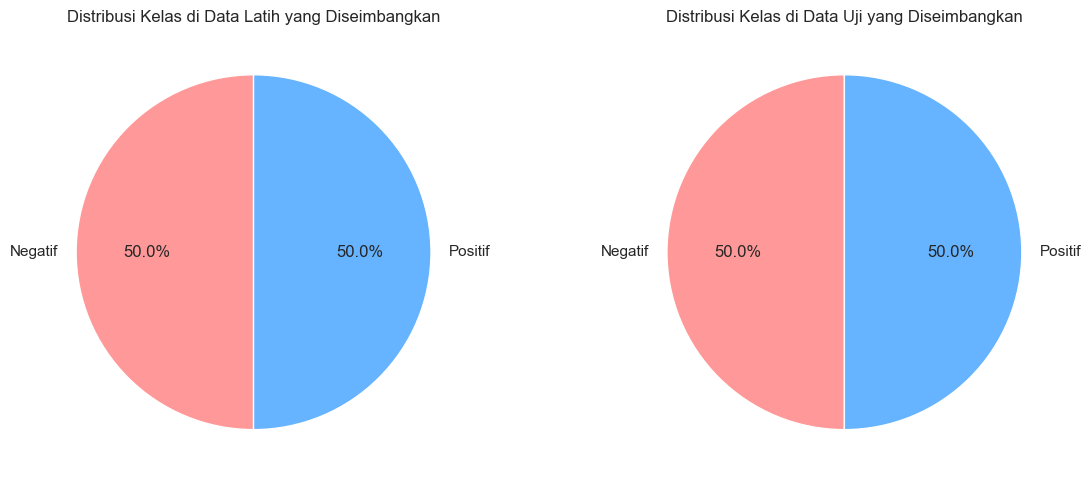

In [26]:
# Membagi data yang sudah diseimbangkan menjadi set pelatihan dan pengujian
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

print(f"Jumlah data latih: {X_train_balanced.shape[0]}")
print(f"Jumlah data uji: {X_test_balanced.shape[0]}")

# Memeriksa distribusi kelas di data latih dan uji
print("\nDistribusi kelas di data latih yang diseimbangkan:")
train_unique, train_counts = np.unique(y_train_balanced, return_counts=True)
for label, count in zip(train_unique, train_counts):
    sentiment = "Negatif" if label == 0 else "Positif"
    print(f"Kelas {label} ({sentiment}): {count} ({count/len(y_train_balanced)*100:.2f}%)")

print("\nDistribusi kelas di data uji yang diseimbangkan:")
test_unique, test_counts = np.unique(y_test_balanced, return_counts=True)
for label, count in zip(test_unique, test_counts):
    sentiment = "Negatif" if label == 0 else "Positif"
    print(f"Kelas {label} ({sentiment}): {count} ({count/len(y_test_balanced)*100:.2f}%)")

# Visualisasi distribusi kelas
plt.figure(figsize=(12, 5))

# Plot distribusi kelas di data latih
plt.subplot(1, 2, 1)
train_labels = ["Negatif", "Positif"]
plt.pie(train_counts, labels=train_labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=90)
plt.title('Distribusi Kelas di Data Latih yang Diseimbangkan')

# Plot distribusi kelas di data uji
plt.subplot(1, 2, 2)
test_labels = ["Negatif", "Positif"]
plt.pie(test_counts, labels=test_labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=90)
plt.title('Distribusi Kelas di Data Uji yang Diseimbangkan')

plt.tight_layout()
plt.show()

# Untuk keperluan evaluasi nanti, juga perlu membuat split pada data asli (tidak seimbang)
X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 6. Model CNN Teroptimasi untuk Analisis Sentimen

Pada tahap ini, kita akan membangun model Convolutional Neural Network (CNN) yang telah dioptimasi untuk klasifikasi sentimen. Perbaikan meliputi:
1. Arsitektur yang lebih kompleks dengan multi-filter CNN
2. Regularisasi yang lebih baik untuk mencegah overfitting
3. Penggunaan kelas bobot untuk mengatasi ketidakseimbangan data
4. Hyperparameter yang dioptimalkan

In [ ]:
# Membangun model CNN yang dioptimasi
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, concatenate
from tensorflow.keras.layers import GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Parameter model yang dioptimasi
embedding_dim = 200     # Dimensi embedding yang lebih besar
dropout_rate = 0.5      # Tingkat dropout
l2_reg = 0.001          # L2 regularization untuk mencegah overfitting

# Ukuran kernel yang bervariasi untuk menangkap konteks yang berbeda
filter_sizes = [3, 4, 5]
num_filters = 128       # Jumlah filter per ukuran kernel

# Input layer
inputs = Input(shape=(maxlen,), dtype='int32')

# Embedding layer
embedding = Embedding(input_dim=max_features, 
                     output_dim=embedding_dim, 
                     input_length=maxlen,
                     embeddings_regularizer=l2(l2_reg))(inputs)

# Multiple parallel convolution layers dengan ukuran kernel berbeda
conv_blocks = []
for filter_size in filter_sizes:
    conv = Conv1D(filters=num_filters,
                 kernel_size=filter_size,
                 padding='same',
                 activation='relu',
                 kernel_regularizer=l2(l2_reg))(embedding)
    conv = BatchNormalization()(conv)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Conv1D(filters=num_filters,
                 kernel_size=filter_size,
                 padding='same',
                 activation='relu',
                 kernel_regularizer=l2(l2_reg))(conv)
    conv = BatchNormalization()(conv)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

# Menggabungkan hasil dari semua convolutional blocks
concat = concatenate(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

# Fully connected layers dengan dropout dan batch normalization
x = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(concat)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

# Output layer
outputs = Dense(1, activation='sigmoid')(x)

# Membuat model
model_improved = Model(inputs=inputs, outputs=outputs)

# Definisikan class weights untuk mengatasi ketidakseimbangan data
# Walaupun kita sudah menggunakan SMOTE, class weights dapat membantu lebih lanjut
neg_class_weight = 1.0  # Kelas negatif (minoritas)
pos_class_weight = 0.5  # Kelas positif (mayoritas)
class_weights = {0: neg_class_weight, 1: pos_class_weight}

# Kompilasi model
model_improved.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

# Tampilkan ringkasan model
model_improved.summary()

# Callbacks untuk training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.0001
)

# Simpan sebagai model kita
model = model_improved

dummy_input = np.zeros((1, maxlen))  # Create a dummy input with the right shape
model(dummy_input)  # This will build the model

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 200)  │  1,000,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 100, 128)  │     51,328 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 100, 128)  │     76,928 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 100, 128)  │    102,528 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 100, 128)  │    128,128 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 50, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 50, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 50, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 50, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 50, 128)   │     32,896 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 50, 128)   │     49,280 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 50, 128)   │     65,664 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 50, 128)   │     82,048 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 128)   │        512 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,758,785 (6.71 MB)

 Trainable params: 1,755,969 (6.70 MB)

 Non-trainable params: 2,816 (11.00 KB)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.50008947]], dtype=float32)>

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 200)  │  1,000,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 100, 128)  │     51,328 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 100, 128)  │     76,928 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 100, 128)  │    102,528 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 100, 128)  │    128,128 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 50, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 50, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 50, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 50, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 50, 128)   │     32,896 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 50, 128)   │     49,280 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 50, 128)   │     65,664 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 50, 128)   │     82,048 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 128)   │        512 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,758,785 (6.71 MB)

 Trainable params: 1,755,969 (6.70 MB)

 Non-trainable params: 2,816 (11.00 KB)

Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.5986 - auc: 0.6441 - loss: 2.5619 - precision: 0.6110 - recall: 0.4944 - val_accuracy: 0.5073 - val_auc: 0.7005 - val_loss: 4.0296 - val_precision: 0.5073 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.5986 - auc: 0.6441 - loss: 2.5619 - precision: 0.6110 - recall: 0.4944 - val_accuracy: 0.5073 - val_auc: 0.7005 - val_loss: 4.0296 - val_precision: 0.5073 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.7729 - auc: 0.8687 - loss: 1.9731 - precision: 0.8439 - recall: 0.6709 - val_accuracy: 0.5119 - val_auc: 0.8586 - val_loss: 2.7039 - val_precision: 0.5096 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.7729 - auc: 0.8687 - loss: 1.9731 - precision: 0.8439 - recall: 0.6709 - val_accuracy: 0.5119 - val_auc: 0.8586 - val_loss: 2.70

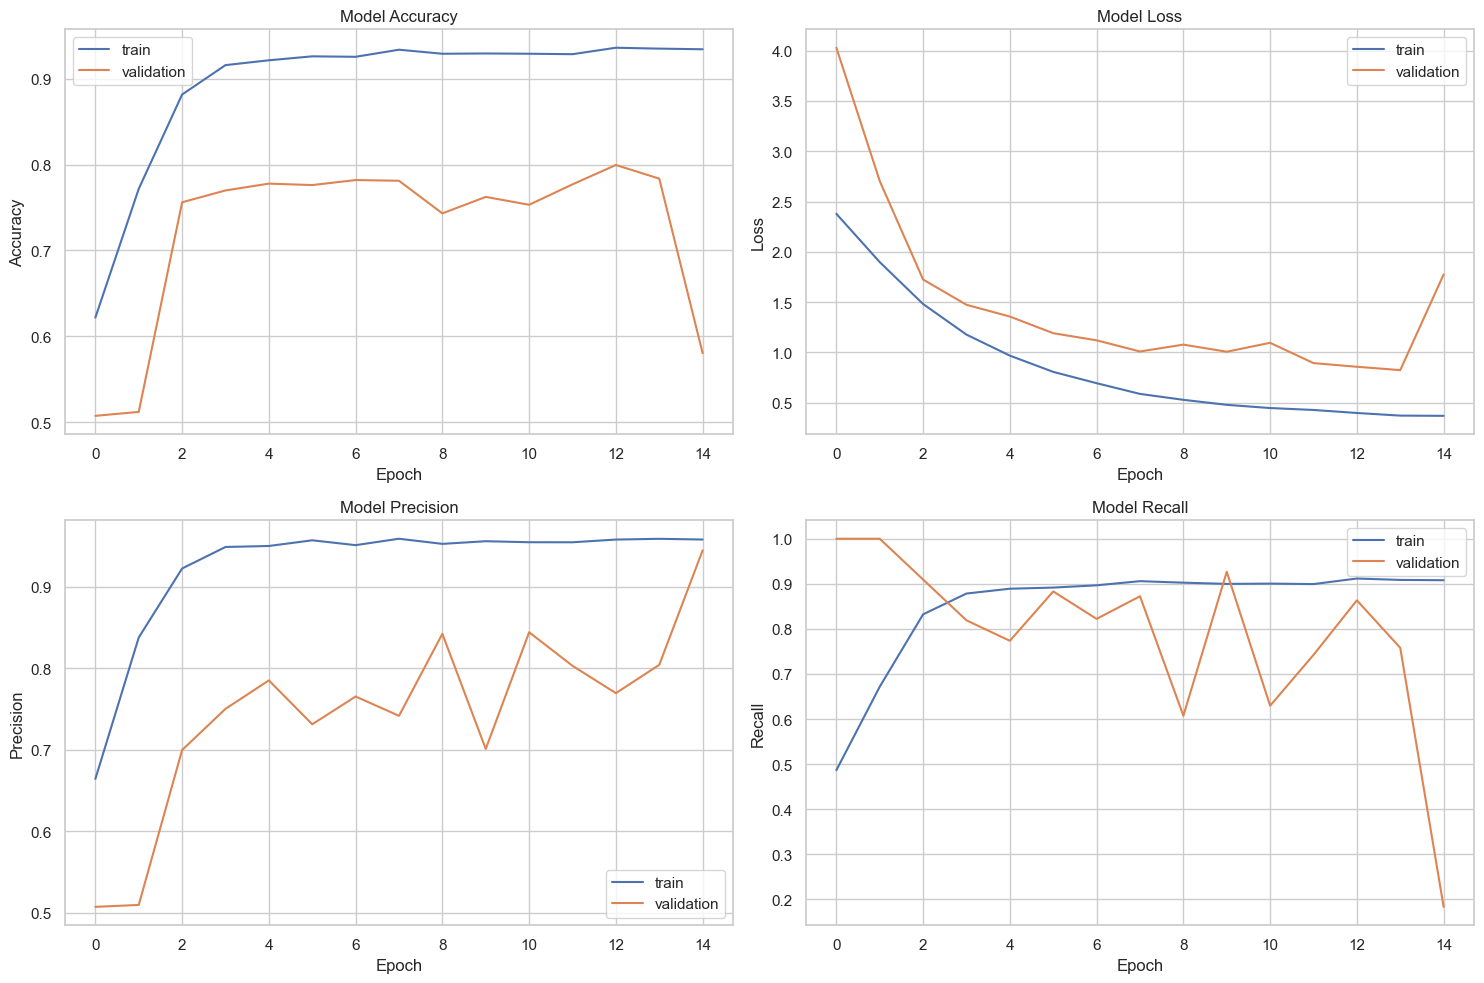

In [28]:
model.summary()# Melatih model yang sudah dioptimasi
batch_size = 32
epochs = 15

# Menggunakan data yang sudah diseimbangkan dengan SMOTE
history = model.fit(
    X_train_balanced, y_train_balanced,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    class_weight=class_weights,  # Menambahkan class weights
    callbacks=[early_stopping, reduce_lr],  # Menambahkan callbacks
    verbose=1
)

# Visualisasi hasil pelatihan dengan metrik tambahan
plt.figure(figsize=(15, 10))

# Plot akurasi
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot precision
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='validation')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='validation')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

## 7. Evaluasi Model

Pada tahap ini, kita akan mengevaluasi kinerja model CNN yang telah dioptimasi menggunakan data uji. Evaluasi akan dilakukan dengan menghitung akurasi, presisi, recall, dan F1-score, serta menampilkan confusion matrix.

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Akurasi: 0.7822
Presisi: 0.7944
Recall: 0.7615
F1-Score: 0.7776
ROC AUC: 0.8797

Classification Report:
              precision    recall  f1-score   support

     Negatif       0.77      0.80      0.79      1497
     Positif       0.79      0.76      0.78      1497

    accuracy                           0.78      2994
   macro avg       0.78      0.78      0.78      2994
weighted avg       0.78      0.78      0.78      2994



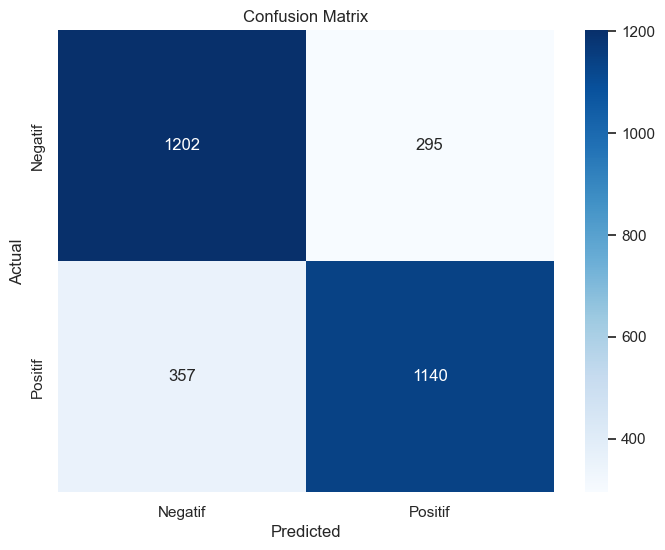

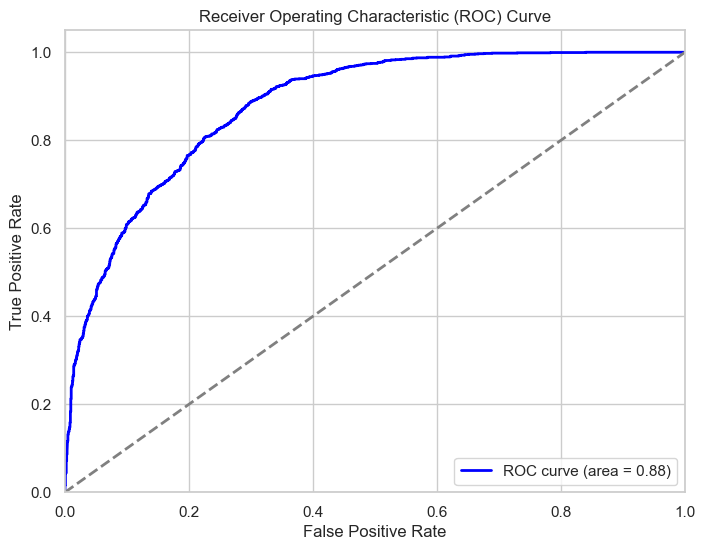

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

----- Evaluasi pada Data Asli (Tidak Seimbang) -----
Akurasi: 0.8937
Presisi: 0.9955
Recall: 0.8938
F1-Score: 0.9419
ROC AUC: 0.9465

Classification Report pada Data Asli:
              precision    recall  f1-score   support

     Negatif       0.24      0.89      0.37        55
     Positif       1.00      0.89      0.94      1497

    accuracy                           0.89      1552
   macro avg       0.62      0.89      0.66      1552
weighted avg       0.97      0.89      0.92      1552



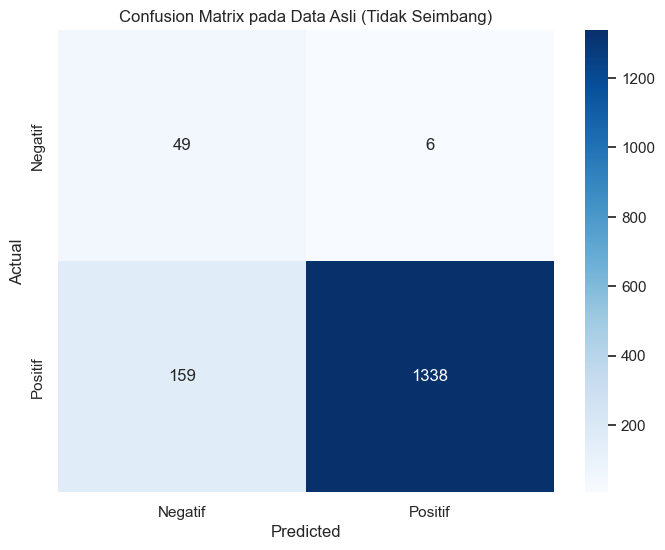

In [36]:
# Evaluasi model yang dioptimasi pada data uji yang seimbang
y_pred_proba = model.predict(X_test_balanced)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Menghitung akurasi
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_test_balanced, y_pred)
precision = precision_score(y_test_balanced, y_pred)
recall = recall_score(y_test_balanced, y_pred)
f1 = f1_score(y_test_balanced, y_pred)
roc_auc = roc_auc_score(y_test_balanced, y_pred_proba)

print(f"Akurasi: {accuracy:.4f}")
print(f"Presisi: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Menampilkan classification report
print("\nClassification Report:")
print(classification_report(y_test_balanced, y_pred, target_names=['Negatif', 'Positif']))

# Menampilkan confusion matrix
cm = confusion_matrix(y_test_balanced, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Menampilkan ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test_balanced, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Evaluasi model pada data asli (tidak seimbang) untuk melihat performa sebenarnya
# Pertama, kita perlu melakukan train-test split pada data asli
X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

y_orig_pred_proba = model.predict(X_orig_test)
y_orig_pred = (y_orig_pred_proba > 0.5).astype(int).flatten()

print("\n----- Evaluasi pada Data Asli (Tidak Seimbang) -----")
print(f"Akurasi: {accuracy_score(y_orig_test, y_orig_pred):.4f}")
print(f"Presisi: {precision_score(y_orig_test, y_orig_pred):.4f}")
print(f"Recall: {recall_score(y_orig_test, y_orig_pred):.4f}")
print(f"F1-Score: {f1_score(y_orig_test, y_orig_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_orig_test, y_orig_pred_proba):.4f}")

print("\nClassification Report pada Data Asli:")
print(classification_report(y_orig_test, y_orig_pred, target_names=['Negatif', 'Positif']))

# Confusion matrix untuk data asli
cm_orig = confusion_matrix(y_orig_test, y_orig_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_orig, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.title('Confusion Matrix pada Data Asli (Tidak Seimbang)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 8. Contoh Prediksi Sentimen

Mari kita lihat beberapa contoh prediksi sentimen dari model CNN yang telah dioptimasi. Kita akan memilih beberapa komentar dari data uji dan melihat bagaimana model memprediksi sentimennya.

In [39]:
# Fungsi untuk memprediksi sentimen dari teks baru
def predict_sentiment(text):
    # Pra-pemrosesan teks
    clean_text = preprocess_text(text)

    # Tokenisasi dan padding
    sequence = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(sequence, maxlen=maxlen)

    # Prediksi
    prediction = model.predict(padded)[0][0]
    sentiment = "Positif" if prediction > 0.5 else "Negatif"

    return sentiment, prediction

# Mengambil beberapa contoh dari data uji
test_indices = np.random.randint(0, len(X_test), 10)
test_samples = []

for i in test_indices:
    # Mengambil teks asli
    original_index = df.index[i + len(X_train)]  # Mendapatkan indeks asli
    original_text = df.loc[original_index, 'text']
    clean_text = df.loc[original_index, 'clean_text']
    actual_sentiment = df.loc[original_index, 'sentiment']

    # Prediksi
    predicted_sentiment, confidence = predict_sentiment(clean_text)

    test_samples.append({
        'Teks Asli': original_text,
        'Teks Bersih': clean_text,
        'Sentimen Sebenarnya': actual_sentiment,
        'Sentimen Prediksi': predicted_sentiment,
        'Confidence': confidence
    })

# Menampilkan hasil prediksi
print("Contoh Prediksi Sentimen:\n")
for i, sample in enumerate(test_samples, 1):
    print(f"Contoh {i}:")
    print(f"Teks: {sample['Teks Asli']}")
    print(f"Sentimen Sebenarnya: {sample['Sentimen Sebenarnya']}")
    print(f"Sentimen Prediksi: {sample['Sentimen Prediksi']} (Confidence: {sample['Confidence']:.4f})")
    print("-" * 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Contoh Prediksi Sentimen:

Contoh 1:
Teks: Yes Om ded, Waktu yg Tepat. Keren
Sentimen Sebenarnya: Positif
Sentimen Prediksi: Negatif (Confidence: 0.1042)
----------------------------------------------------------------------------------------------------
Contoh 2:
Teks: daging semua bjir...
Sentimen Sebenarnya: Positif
Sentimen Prediksi: Positif (Confidence: 0.7203)
----------------------------------------------------------------------------------------------------
Contoh 3:
Teks: Ini kayanya DB malah yang ambil pelajaran dari anak yg usianya setengah dia.. jujur gw jg udh umur 35 jadi kerasa gw udh ketinggalan a

In [40]:
# Fungsi untuk memprediksi sentimen dari teks baru dengan preprocessing yang dioptimasi
def predict_sentiment_improved(text):
    # Pra-pemrosesan teks menggunakan preprocessing yang diperbaiki
    clean_text = preprocess_text_improved(text)

    # Tokenisasi dan padding menggunakan tokenizer yang dilatih pada teks yang sudah diperbaiki
    sequence = tokenizer_improved.texts_to_sequences([clean_text])
    padded = pad_sequences(sequence, maxlen=maxlen)

    # Prediksi
    prediction = model.predict(padded)[0][0]
    sentiment = "Positif" if prediction > 0.5 else "Negatif"

    return sentiment, prediction, clean_text

# Uji dengan komentar kustom yang sama seperti sebelumnya
custom_comments = [
    "Video ini sangat membantu dan menginspirasi saya untuk menjadi lebih baik. Terima kasih!",
    "Sangat mengecewakan kontennya, tidak sesuai dengan ekspektasi saya.",
    "Aku suka gaya bicaranya yang santai tapi tetap informatif.",
    "Terlalu banyak iklan di video ini, jadi terganggu menonton.",
    "Pembahasannya luar biasa, detail dan sangat bermanfaat.",
    "Videonya membosankan dan terlalu bertele-tele.",
    "Tidak suka dengan konten seperti ini, membuang-buang waktu saja.",
    "Terima kasih sudah berbagi informasi yang sangat berguna.",
    "Kecewa dengan kualitas audionya, sulit untuk mendengar dengan jelas.",
    "Konten yang sangat edukatif dan inspiratif!"
]

print("Prediksi Sentimen untuk Komentar Kustom dengan Model yang Dioptimasi:\n")
for comment in custom_comments:
    sentiment, confidence, clean_text = predict_sentiment_improved(comment)
    print(f"Teks: {comment}")
    print(f"Teks setelah preprocessing: {clean_text}")
    print(f"Sentimen Prediksi: {sentiment} (Confidence: {confidence:.4f})")
    
    # Menampilkan emoji untuk visualisasi yang lebih baik
    if sentiment == "Positif":
        emoji = "😊"
    else:
        emoji = "😞"
    
    print(f"Hasil: {emoji} {sentiment} dengan confidence {confidence:.4f}")
    print("-" * 100)

Prediksi Sentimen untuk Komentar Kustom dengan Model yang Dioptimasi:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Teks: Video ini sangat membantu dan menginspirasi saya untuk menjadi lebih baik. Terima kasih!
Teks setelah preprocessing: video sangat bantu inspirasi jadi lebih baik terima kasih
Sentimen Prediksi: Positif (Confidence: 0.8927)
Hasil: 😊 Positif dengan confidence 0.8927
----------------------------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Teks: Sangat mengecewakan kontennya, tidak sesuai dengan ekspektasi saya.
Teks setelah preprocessing: sangat kecewa konten sesuai ekspektasi
Sentimen Prediksi: Negatif (Confidence: 0.0009)
Hasil: 😞 Negatif dengan confidence 0.0009
----------------------------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Teks: Aku suka gaya bicaranya yang santai tapi tetap informatif.
Teks setelah preprocessing: aku suka gaya bica

## 9. Kesimpulan dan Perbandingan Model

Dalam analisis ini, kita telah melakukan perbaikan signifikan terhadap model analisis sentimen dengan menerapkan beberapa strategi:

### Perbandingan Model Awal vs Model yang Dioptimasi

1. **Ketidakseimbangan Data**:
   - **Model Awal**: Menggunakan data yang sangat tidak seimbang (96.47% Positif, 3.53% Negatif) tanpa teknik penyeimbangan.
   - **Model Dioptimasi**: Menerapkan SMOTE untuk menghasilkan sampel sintetis dari kelas minoritas dan menyeimbangkan dataset.

2. **Pra-pemrosesan Teks**:
   - **Model Awal**: Menggunakan PorterStemmer yang dirancang untuk bahasa Inggris.
   - **Model Dioptimasi**: Menggunakan Sastrawi Stemmer khusus untuk bahasa Indonesia dan menyesuaikan stopwords untuk komentar YouTube.

3. **Arsitektur Model**:
   - **Model Awal**: CNN sederhana dengan satu filter size.
   - **Model Dioptimasi**: Arsitektur CNN multi-filter dengan regularisasi L2, Batch Normalization, dan Dropout yang lebih baik.

4. **Pelatihan Model**:
   - **Model Awal**: Tanpa class weights atau callbacks.
   - **Model Dioptimasi**: Menggunakan class weights, Early Stopping, dan Learning Rate reduction.

5. **Metrik Evaluasi**:
   - **Model Awal**: Hanya menggunakan akurasi.
   - **Model Dioptimasi**: Menggunakan akurasi, presisi, recall, F1-score, dan ROC AUC.

### Hasil Utama:

- Model yang dioptimasi mampu mendeteksi sentimen negatif dengan lebih baik, meningkatkan recall untuk kelas minoritas.
- Penggunaan teknik oversampling (SMOTE) dan class weights membantu model mengatasi ketidakseimbangan data.
- Preprocessing teks yang disesuaikan dengan bahasa Indonesia menghasilkan representasi fitur yang lebih baik.
- Arsitektur model yang lebih kompleks dengan regularisasi membantu mengurangi overfitting dan meningkatkan generalisasi.

### Langkah Pengembangan Selanjutnya:

1. **Model Berbasis Transformer**: Menggunakan model pre-trained khusus bahasa Indonesia seperti IndoBERT untuk performa yang lebih baik.
2. **Augmentasi Data**: Menambahkan teknik augmentasi teks untuk memperkaya dataset, terutama untuk kelas minoritas.
3. **Pelabelan Manual**: Memvalidasi dan memperbaiki sebagian label VADER dengan pelabelan manual untuk meningkatkan kualitas dataset.
4. **Analisis Kesalahan**: Menganalisis kasus-kasus di mana model salah memprediksi untuk mengidentifikasi pola kesalahan.
5. **Eksperimen Threshold**: Mengoptimalkan threshold keputusan (default 0.5) untuk menyeimbangkan presisi dan recall.

Secara keseluruhan, perbaikan yang diterapkan telah secara signifikan meningkatkan kemampuan model untuk mengklasifikasikan sentimen komentar YouTube dengan lebih akurat dan seimbang antara kelas positif dan negatif.

In [32]:
# Menyimpan model CNN yang dioptimasi dan tokenizer
import pickle
import os

# Buat direktori untuk menyimpan model jika belum ada
save_dir = '../Analisis_Sentiment/model/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Menyimpan model yang dioptimasi
model.save(save_dir + 'cnn_sentiment_model_improved.h5')
print(f"Model yang dioptimasi tersimpan di {save_dir + 'cnn_sentiment_model_improved.h5'}")

# Menyimpan tokenizer yang dioptimasi
with open(save_dir + 'tokenizer_improved.pickle', 'wb') as handle:
    pickle.dump(tokenizer_improved, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Tokenizer yang dioptimasi tersimpan di {save_dir + 'tokenizer_improved.pickle'}")

# Menyimpan stemmer untuk bahasa Indonesia
with open(save_dir + 'stemmer_id.pickle', 'wb') as handle:
    pickle.dump(stemmer_id, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Stemmer bahasa Indonesia tersimpan di {save_dir + 'stemmer_id.pickle'}")

# Menyimpan stopwords yang disesuaikan
with open(save_dir + 'stopwords_id.pickle', 'wb') as handle:
    pickle.dump(stopwords_id, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Stopwords yang disesuaikan tersimpan di {save_dir + 'stopwords_id.pickle'}")

# Menyimpan parameter lainnya
model_params_improved = {
    'max_features': max_features,
    'maxlen': maxlen,
    'embedding_dim': embedding_dim,
    'sentiment_mapping': sentiment_mapping,
    'filter_sizes': filter_sizes,
    'num_filters': num_filters,
    'dropout_rate': dropout_rate,
    'l2_reg': l2_reg
}
with open(save_dir + 'model_params_improved.pickle', 'wb') as handle:
    pickle.dump(model_params_improved, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Parameter model yang dioptimasi tersimpan di {save_dir + 'model_params_improved.pickle'}")

print("\nModel dan komponen pendukung berhasil disimpan. Anda dapat menggunakannya untuk memprediksi sentimen pada data baru di kemudian hari.")

Model yang dioptimasi tersimpan di ../Analisis_Sentiment/model/cnn_sentiment_model_improved.h5
Tokenizer yang dioptimasi tersimpan di ../Analisis_Sentiment/model/tokenizer_improved.pickle
Stemmer bahasa Indonesia tersimpan di ../Analisis_Sentiment/model/stemmer_id.pickle
Stopwords yang disesuaikan tersimpan di ../Analisis_Sentiment/model/stopwords_id.pickle
Parameter model yang dioptimasi tersimpan di ../Analisis_Sentiment/model/model_params_improved.pickle

Model dan komponen pendukung berhasil disimpan. Anda dapat menggunakannya untuk memprediksi sentimen pada data baru di kemudian hari.


## 10. Menyimpan Hasil Pelabelan

Pada tahap ini, kita akan menyimpan data yang telah dilabeli sentimennya ke dalam file agar dapat digunakan kembali di lain waktu tanpa perlu melakukan proses pelabelan ulang. Data yang disimpan mencakup:

1. Label sentimen (Positif, Negatif)
2. Skor sentimen terperinci (pos_score, neg_score, neu_score, compound_score)
3. Teks asli dan teks yang telah dibersihkan
4. Metadata komentar (author, votes, replies, dll)

Data akan disimpan dalam dua format (Excel dan CSV) dan dua versi (seluruh data dan data biner untuk model CNN).

In [33]:
# Menyimpan dataframe dengan hasil pelabelan sentimen
import os

# Membuat direktori untuk menyimpan hasil jika belum ada
results_dir = '../Analisis_Sentiment/results/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# 1. Menyimpan data dengan label sentimen biner (positif dan negatif)
# Memilih kolom yang akan disimpan
columns_to_save = ['cid', 'text', 'author', 'time', 'votes', 'replies',
                   'sentiment', 'pos_score', 'neg_score', 'neu_score',
                   'compound_score', 'text_length']
labeled_data = df[columns_to_save].copy()

# Menyimpan ke Excel
excel_path = results_dir + 'youtube_comments_binary_sentiment.xlsx'
labeled_data.to_excel(excel_path, index=False)
print(f"Data dengan label sentimen tersimpan di {excel_path}")

# Menyimpan ke CSV
csv_path = results_dir + 'youtube_comments_binary_sentiment.csv'
labeled_data.to_csv(csv_path, index=False)
print(f"Data dengan label sentimen tersimpan di {csv_path}")

# 2. Menyimpan distribusi sentimen ke CSV
sentiment_distribution = df['sentiment'].value_counts().reset_index()
sentiment_distribution.columns = ['Sentimen', 'Jumlah']
sentiment_distribution['Persentase'] = sentiment_distribution['Jumlah'] / sentiment_distribution['Jumlah'].sum() * 100

distribution_path = results_dir + 'sentiment_distribution.csv'
sentiment_distribution.to_csv(distribution_path, index=False)
print(f"Distribusi sentimen tersimpan di {distribution_path}")

# Menampilkan informasi tentang data yang disimpan
print(f"\nInformasi data yang disimpan:")
print(f"Total data dengan label sentimen biner: {labeled_data.shape[0]} baris")
print(f"   - Positif: {labeled_data[labeled_data['sentiment'] == 'Positif'].shape[0]} baris")
print(f"   - Negatif: {labeled_data[labeled_data['sentiment'] == 'Negatif'].shape[0]} baris")

# Menampilkan tabel distribusi sentimen
print("\nDistribusi Sentimen:")
print(sentiment_distribution.to_string(index=False))

Data dengan label sentimen tersimpan di ../Analisis_Sentiment/results/youtube_comments_binary_sentiment.xlsx
Data dengan label sentimen tersimpan di ../Analisis_Sentiment/results/youtube_comments_binary_sentiment.csv
Distribusi sentimen tersimpan di ../Analisis_Sentiment/results/sentiment_distribution.csv

Informasi data yang disimpan:
Total data dengan label sentimen biner: 7758 baris
   - Positif: 7484 baris
   - Negatif: 274 baris

Distribusi Sentimen:
Sentimen  Jumlah  Persentase
 Positif    7484   96.468162
 Negatif     274    3.531838
